# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(float) / 255.0
    
    # Вычтем среднее арифметическое
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Добавим канал с единицами как постоянное смещение
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Разделим train на train и val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [4]:
def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [5]:
# Реализовали softmax и cross-entropy для единичной выборки
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Убедились, что с большими числами также работает
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [7]:
probs = linear_classifer.softmax(np.array([-10, 0, 10]))
linear_classifer.cross_entropy_loss(probs, 1)

10.000045400960277

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [8]:
# Реализовали функцию, объединяющую softmax и cross entropy и вычисляющую градиент
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float64))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [9]:
np.random.seed(42)
# Тест batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float64)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int32)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Тест batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float64)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int32)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Снова убедимся, что нормирование работает для больших чисел в каждом батче.
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [10]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float64)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float64)
target_index = np.ones(batch_size, dtype=np.int32)
loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [11]:
# Реализовали функцию l2_regularization, вычисляющую ошибку для L2 регуляризации
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [12]:
# Реализовали функцию LinearSoftmaxClassifier.fit
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 690.883617
Epoch 1, loss: 688.211508
Epoch 2, loss: 685.841336
Epoch 3, loss: 683.710981
Epoch 4, loss: 681.806399
Epoch 5, loss: 680.090137
Epoch 6, loss: 678.596557
Epoch 7, loss: 677.321790
Epoch 8, loss: 676.472948
Epoch 9, loss: 676.264172


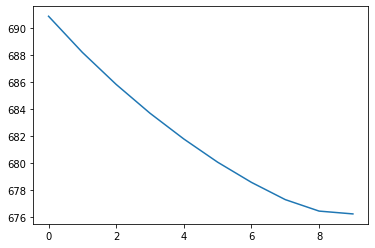

In [13]:
# Посмотрим историю изменения ошибки!
plt.plot(loss_history)

Accuracy:  0.23
Epoch 0, loss: 653.866357
Epoch 1, loss: 653.856968
Epoch 2, loss: 653.847615
Epoch 3, loss: 653.838297
Epoch 4, loss: 653.829012
Epoch 5, loss: 653.819763
Epoch 6, loss: 653.810547
Epoch 7, loss: 653.801366
Epoch 8, loss: 653.792219
Epoch 9, loss: 653.783105
Epoch 10, loss: 653.774025
Epoch 11, loss: 653.764979
Epoch 12, loss: 653.755966
Epoch 13, loss: 653.746986
Epoch 14, loss: 653.738039
Epoch 15, loss: 653.729125
Epoch 16, loss: 653.720244
Epoch 17, loss: 653.711395
Epoch 18, loss: 653.702579
Epoch 19, loss: 653.693795
Epoch 20, loss: 653.685043
Epoch 21, loss: 653.676324
Epoch 22, loss: 653.667636
Epoch 23, loss: 653.658980
Epoch 24, loss: 653.650355
Epoch 25, loss: 653.641762
Epoch 26, loss: 653.633201
Epoch 27, loss: 653.624671
Epoch 28, loss: 653.616171
Epoch 29, loss: 653.607703
Epoch 30, loss: 653.599265
Epoch 31, loss: 653.590858
Epoch 32, loss: 653.582482
Epoch 33, loss: 653.574136
Epoch 34, loss: 653.565820
Epoch 35, loss: 653.557534
Epoch 36, loss: 653.54

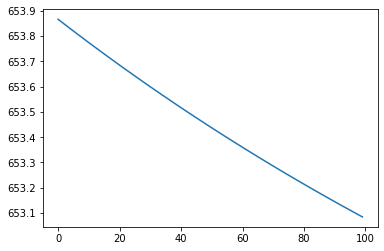

In [23]:
# TODO: Реализовать функцию вычисления точности и посмотреть точность обучения
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Теперь возьмем больше эпох, меньшую скорость обучения и посмотрим как изменится точность
loss_history = classifier.fit(train_X, train_y, batch_size=300, learning_rate=1e-4, reg=1e1, epochs=100)
plt.plot(loss_history);
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

### Как и раньше, используем кросс-валидацию для подбора гиперпараметров.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [44]:
num_epochs = 200
batch_size = 250

learning_rates = [1e-2,1e-3, 1e-4, 1e-5]
reg_strengths = [1e-3,1e-4, 1e-5, 1e-6]

cvdata = []
for lr in learning_rates:
    for rs in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=lr, 
                                batch_size=batch_size, reg=rs)

        prediction = classifier.predict(val_X)
        accuracy = multiclass_accuracy(prediction, val_y)
        cvdata.append(tuple([lr, rs, accuracy]))
        print("lr: {}, rs: {}: accuracy: {}".format(lr, rs, accuracy))

lr: 0.01, rs: 0.001: accuracy: 0.159
lr: 0.01, rs: 0.0001: accuracy: 0.113
lr: 0.01, rs: 1e-05: accuracy: 0.114
lr: 0.01, rs: 1e-06: accuracy: 0.118
lr: 0.001, rs: 0.001: accuracy: 0.211
lr: 0.001, rs: 0.0001: accuracy: 0.205
lr: 0.001, rs: 1e-05: accuracy: 0.205
lr: 0.001, rs: 1e-06: accuracy: 0.205
lr: 0.0001, rs: 0.001: accuracy: 0.229
lr: 0.0001, rs: 0.0001: accuracy: 0.229
lr: 0.0001, rs: 1e-05: accuracy: 0.227
lr: 0.0001, rs: 1e-06: accuracy: 0.228
lr: 1e-05, rs: 0.001: accuracy: 0.171
lr: 1e-05, rs: 0.0001: accuracy: 0.173
lr: 1e-05, rs: 1e-05: accuracy: 0.157
lr: 1e-05, rs: 1e-06: accuracy: 0.164


In [48]:
best_classifier = linear_classifer.LinearSoftmaxClassifier()
cvdata.sort(key = lambda x: float(x[2]), reverse = True)
best_val_lr = cvdata[0][0]
best_val_rs = cvdata[0][1]
best_val_accuracy = cvdata[0][2]

print('best validation accuracy achieved: %f' % best_val_accuracy)

best validation accuracy achieved: 0.229000


In [49]:
train_and_val_X = np.concatenate((train_X, val_X))
train_and_val_y = np.concatenate((train_y, val_y))
best_classifier.fit(train_and_val_X, train_and_val_y, epochs=num_epochs, 
                    learning_rate=best_val_lr, batch_size=batch_size, reg=best_val_rs);

# Какой же точности мы добились на тестовых данных?

In [50]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.192000
